In [254]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

In [2]:
path_csv = "./ESC-50-master/meta/esc50.csv"

In [3]:
df = pd.read_csv(path_csv)

In [4]:
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [5]:
category = ["crying_baby", "sneezing", "clapping", "breathing", "coughing", "footsteps", "laughing", "brushing_teeth", "snoring", "drinking_sipping"]

In [6]:
df = df.loc[df["category"].isin(category)]

In [7]:
df = df.reset_index(drop=True)

In [125]:
sample_num = 1
sr = 44100
max_size = 480
hop_length = 512
n_fft = 255
h = 128
n_mfcc = 128
epoch = 30

In [71]:
s = df.loc[sample_num,['filename']].values[0]
filename= f"./ESC-50-master/audio/{s}"
print(filename)

./ESC-50-master/audio/1-104089-B-22.wav


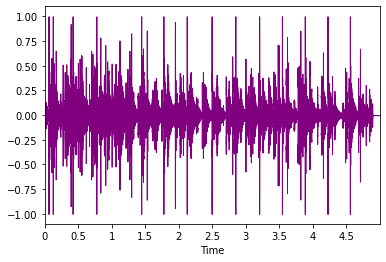

In [72]:
y, sr = librosa.load(filename, sr=sr)
librosa.display.waveplot(y, sr=sr, x_axis='time', color='purple',offset=0.0)

In [73]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [74]:
def generate_features(y_cut):
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=n_fft, hop_length = hop_length)), h, max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length = hop_length,n_mfcc=n_mfcc),h,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    
    for i in range(0,9):
        image = np.append(image, padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image

In [75]:
result = generate_features(y)

In [76]:
result.shape

(128, 480, 3)

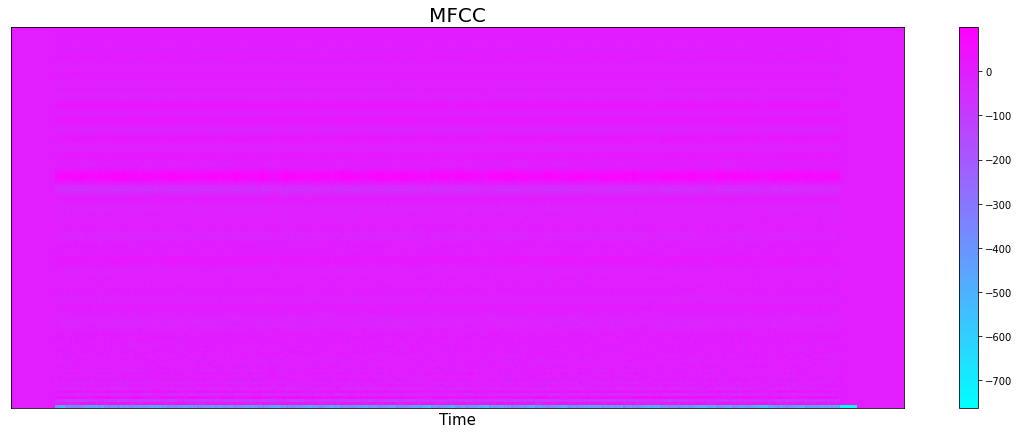

In [77]:
MFCCs = padding(librosa.feature.mfcc(y, n_fft=n_fft, hop_length=hop_length,n_mfcc=n_mfcc),h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

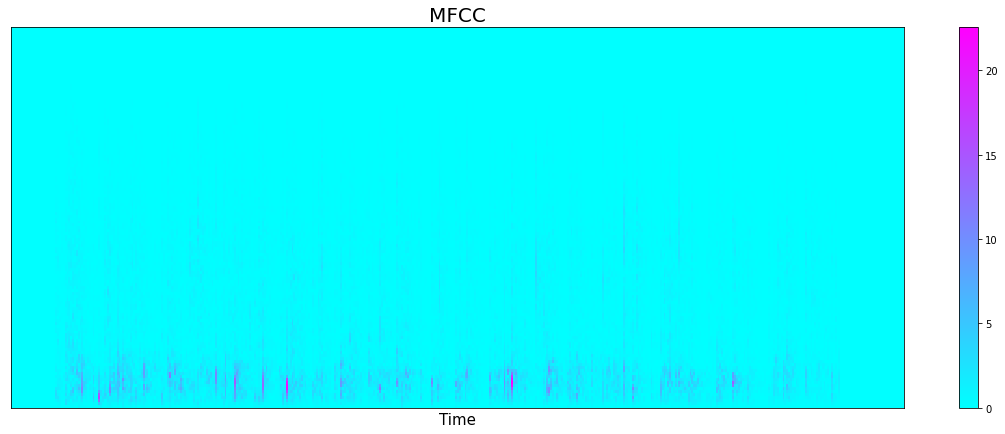

In [78]:
stft = padding(np.abs(librosa.stft(y, n_fft=n_fft, hop_length = hop_length)), h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(stft,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

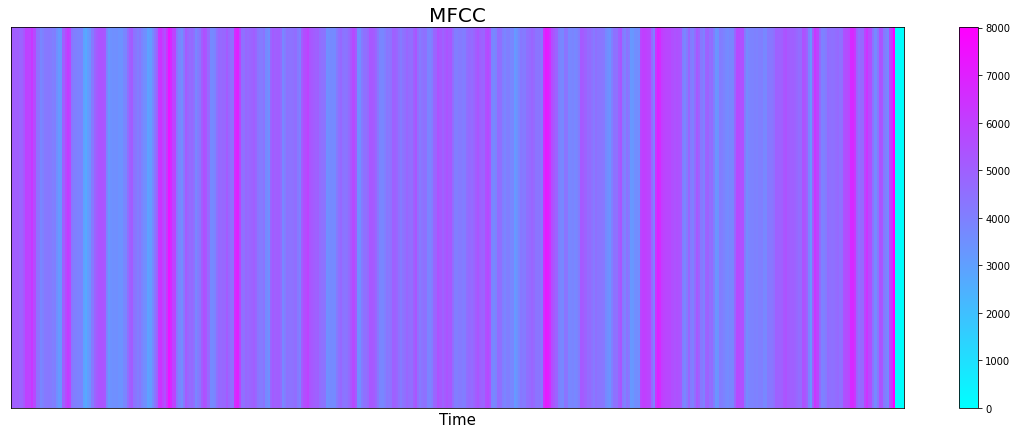

In [79]:
spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_centroid,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

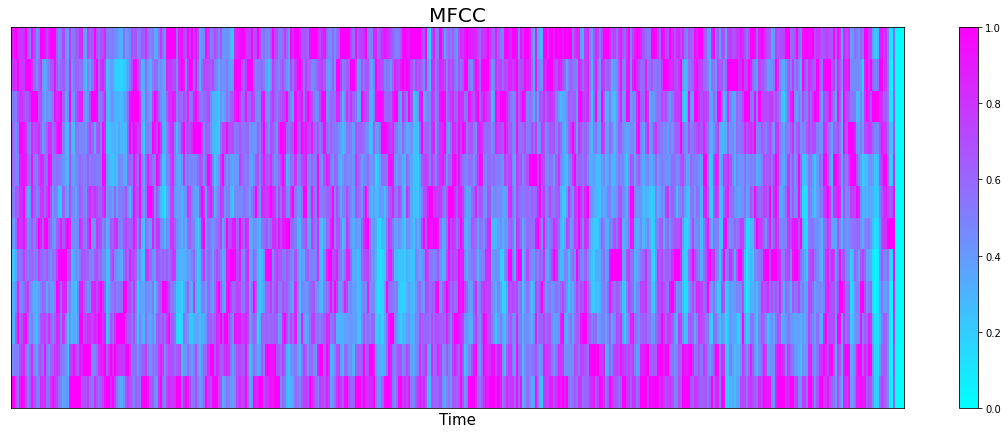

In [80]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(chroma_stft,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

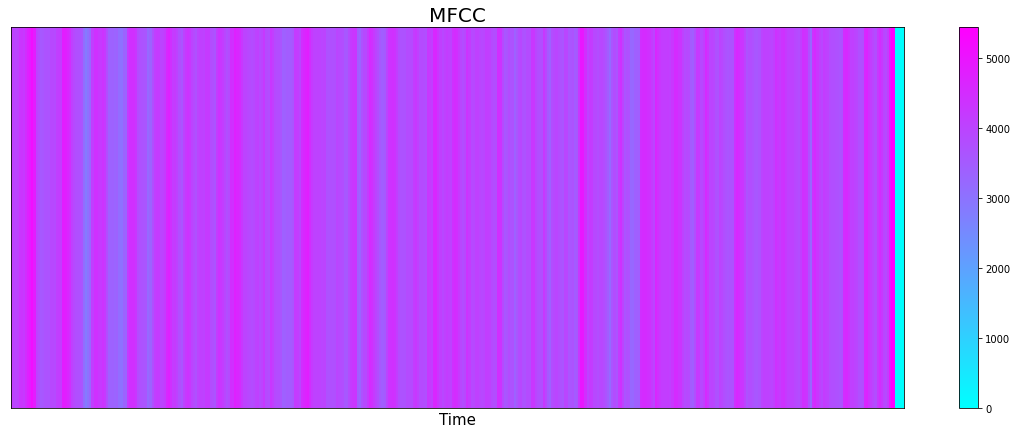

In [81]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_bw,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

In [82]:
def get_features(df_in, rs=None):   
    features=[]
    labels = []
    
    for index, row in df_in.iterrows():
        label = df.loc[index,['category']].values[0]
        s = df.loc[index,['filename']].values[0]
        filename = f"./ESC-50-master/audio/{s}" 
        y, sr = librosa.load(filename,sr=44100)
        data = generate_features(y)
        if not rs is None:
            data = resize(data, rs)
        features.append(data[np.newaxis,...])    
        labels.append(label)     
    output=np.concatenate(features,axis=0)     
    return(np.array(output), labels)

In [83]:
X, y = get_features(df, rs=(224,224))

In [84]:
enc = LabelEncoder()
enc.fit(y)
y = enc.transform(y)
n_classes = len(enc.classes_)

In [85]:
X.shape

(400, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


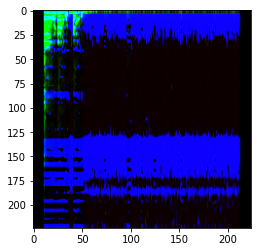

In [86]:
plt.imshow(X[144])

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((225, 224, 224, 3), (100, 224, 224, 3), (75, 224, 224, 3), 225, 100, 75)

In [88]:
X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
X_test = np.array((X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)))
X_val = np.array((X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val)))
X_train = X_train/np.std(X_train)
X_test = X_test/np.std(X_test)
X_val = X_val/np.std(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

# Sequential

In [256]:
input_shape=(224,224,3)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [257]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [258]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=12, validation_data= (X_val, y_val))

Epoch 1/30
19/19 [==============================] - 1s 35ms/step - loss: 18.0650 - accuracy: 0.1255 - val_loss: 2.8550 - val_accuracy: 0.0800
Epoch 2/30
19/19 [==============================] - 1s 27ms/step - loss: 3.8961 - accuracy: 0.1202 - val_loss: 2.3074 - val_accuracy: 0.0800
Epoch 3/30
19/19 [==============================] - 0s 27ms/step - loss: 2.5276 - accuracy: 0.0846 - val_loss: 2.3022 - val_accuracy: 0.1067
Epoch 4/30
19/19 [==============================] - 0s 26ms/step - loss: 2.3377 - accuracy: 0.0987 - val_loss: 2.3037 - val_accuracy: 0.1067
Epoch 5/30
19/19 [==============================] - 0s 26ms/step - loss: 2.3121 - accuracy: 0.1020 - val_loss: 2.3030 - val_accuracy: 0.1067
Epoch 6/30
19/19 [==============================] - 1s 27ms/step - loss: 2.3025 - accuracy: 0.1077 - val_loss: 2.3029 - val_accuracy: 0.1067
Epoch 7/30
19/19 [==============================] - 1s 27ms/step - loss: 2.3025 - accuracy: 0.0966 - val_loss: 2.3029 - val_accuracy: 0.1067
Epoch 8/30
1

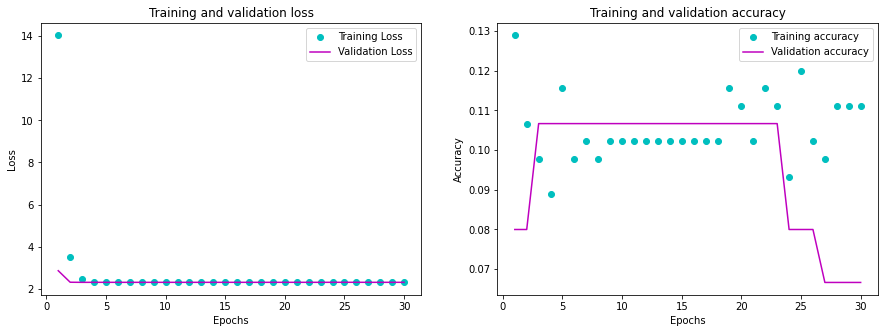

In [259]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

# VGG 16

In [167]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [178]:
n_batch = 10

In [179]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)

In [180]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=opt ,loss=loss, metrics=['accuracy'])

In [181]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 10s 256ms/step - loss: 7989762858.7751 - accuracy: 0.0947 - val_loss: 841230.5625 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 3s 140ms/step - loss: 439955.5391 - accuracy: 0.0796 - val_loss: 3997.1575 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 142ms/step - loss: 5272304.2047 - accuracy: 0.0385 - val_loss: 18877.1426 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 142ms/step - loss: 444695.1174 - accuracy: 0.0953 - val_loss: 13541.2188 - val_accuracy: 0.0933
Epoch 5/30
23/23 [==============================] - 3s 141ms/step - loss: 4534.0795 - accuracy: 0.1352 - val_loss: 2.5880 - val_accuracy: 0.1067
Epoch 6/30
23/23 [==============================] - 3s 142ms/step - loss: 2.5079 - accuracy: 0.1332 - val_loss: 2.4602 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3713 - accuracy: 0.1370 - v

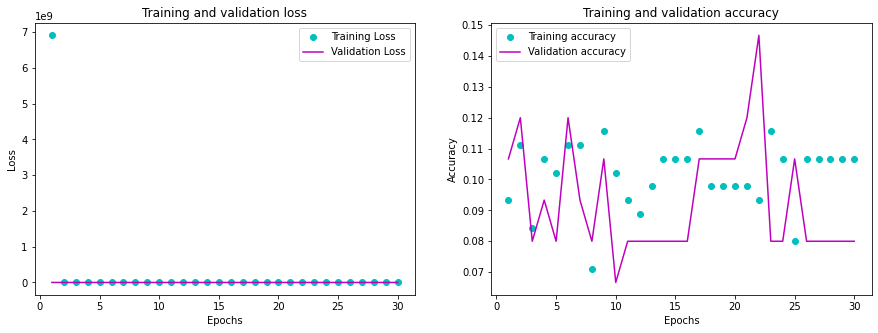

In [134]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [182]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)

In [183]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=opt ,loss=loss, metrics=['accuracy'])

In [184]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 150ms/step - loss: 13.5658 - accuracy: 0.1175 - val_loss: 2.3038 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3026 - accuracy: 0.0663 - val_loss: 2.3047 - val_accuracy: 0.0933
Epoch 3/30
23/23 [==============================] - 3s 142ms/step - loss: 2.3007 - accuracy: 0.0885 - val_loss: 2.3066 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3046 - accuracy: 0.0947 - val_loss: 2.3075 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 142ms/step - loss: 2.3014 - accuracy: 0.1219 - val_loss: 2.3098 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 143ms/step - loss: 2.3016 - accuracy: 0.1085 - val_loss: 2.3106 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 3s 142ms/step - loss: 2.3047 - accuracy: 0.0832 - val_loss: 2.3111 - val_accuracy: 0.0667
Epoch

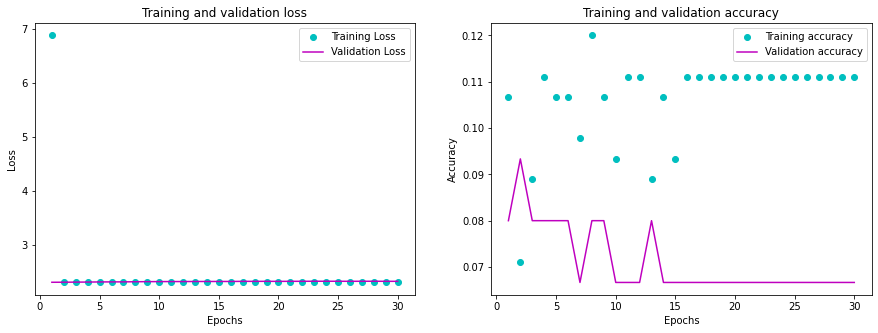

In [185]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [186]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)

In [187]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=opt ,loss=loss, metrics=['accuracy'])

In [188]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 150ms/step - loss: 2.4705 - accuracy: 0.1455 - val_loss: 2.3101 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 142ms/step - loss: 2.2938 - accuracy: 0.1517 - val_loss: 2.2812 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 3s 145ms/step - loss: 2.2917 - accuracy: 0.1258 - val_loss: 2.2487 - val_accuracy: 0.1467
Epoch 4/30
23/23 [==============================] - 3s 143ms/step - loss: 2.2432 - accuracy: 0.1528 - val_loss: 2.2641 - val_accuracy: 0.1067
Epoch 5/30
23/23 [==============================] - 3s 142ms/step - loss: 2.1949 - accuracy: 0.1764 - val_loss: 2.2690 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 3s 142ms/step - loss: 2.1040 - accuracy: 0.1801 - val_loss: 2.2348 - val_accuracy: 0.1067
Epoch 7/30
23/23 [==============================] - 3s 142ms/step - loss: 2.1749 - accuracy: 0.1572 - val_loss: 2.1683 - val_accuracy: 0.1733
Epoch 

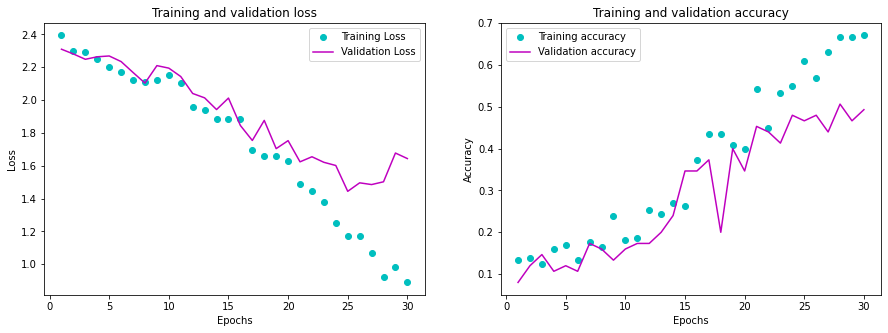

In [189]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [191]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 68ms/step - loss: 1.3899 - accuracy: 0.6000
Confusion_matrix:  tf.Tensor(
[[ 6  0  0  0  1  0  1  1  0  1]
 [ 0  9  0  0  1  0  0  0  0  0]
 [ 1  0  7  0  0  0  0  1  1  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 1  0  0  0  9  0  0  0  0  0]
 [ 2  0  0  2  1  3  0  0  1  1]
 [ 3  3  0  0  0  1  3  0  0  0]
 [ 2  0  0  5  0  0  0  3  0  0]
 [ 0  0  0  4  0  0  0  0  6  0]
 [ 2  2  0  0  0  1  1  0  0  4]], shape=(10, 10), dtype=int32)


# Primer exito

In [192]:
model.save('Model-CNN-vgg16-30e-bs-10-lro-0.0001.h5')

# Optimizador SGD

In [283]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save('base.h5')

In [284]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=opt ,loss=loss, metrics=['accuracy'])

In [285]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 150ms/step - loss: 2.4696 - accuracy: 0.1191 - val_loss: 2.4147 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 140ms/step - loss: 2.3352 - accuracy: 0.1284 - val_loss: 2.3597 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 141ms/step - loss: 2.3152 - accuracy: 0.1111 - val_loss: 2.3269 - val_accuracy: 0.0933
Epoch 4/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2896 - accuracy: 0.1258 - val_loss: 2.3058 - val_accuracy: 0.1733
Epoch 5/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2863 - accuracy: 0.1515 - val_loss: 2.2871 - val_accuracy: 0.1733
Epoch 6/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2743 - accuracy: 0.1849 - val_loss: 2.2691 - val_accuracy: 0.1600
Epoch 7/30
23/23 [==============================] - 3s 141ms/step - loss: 2.2304 - accuracy: 0.1860 - val_loss: 2.2462 - val_accuracy: 0.1467
Epoch 

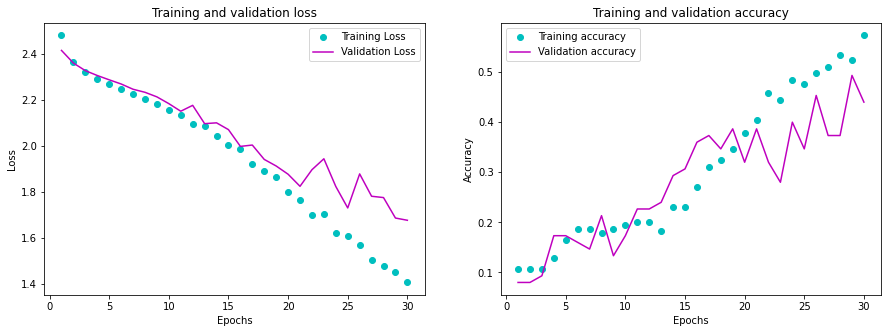

In [286]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [287]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 71ms/step - loss: 1.6111 - accuracy: 0.4200
Confusion_matrix:  tf.Tensor(
[[ 2  0  5  0  1  0  0  0  0  2]
 [ 0  3  6  0  0  0  0  0  0  1]
 [ 0  0  9  1  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  2  6  1]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  1  1  0  1  0  4  3]
 [ 0  3  1  1  0  0  2  0  0  3]
 [ 2  0  2  1  0  0  0  2  1  2]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 1  3  0  1  1  0  0  0  0  4]], shape=(10, 10), dtype=int32)


# Segundo exito

In [289]:
model.save('Model-CNN-vgg16-30e-bs-10-lro-0.0001-opt-sgd.h5')

# Mejora de SGD LR 0,001

In [302]:
baseModel = VGG16(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save('base2.h5')

In [303]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=opt ,loss=loss, metrics=['accuracy'])

In [304]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 150ms/step - loss: 2.5126 - accuracy: 0.0749 - val_loss: 2.3307 - val_accuracy: 0.1867
Epoch 2/30
23/23 [==============================] - 3s 140ms/step - loss: 2.3314 - accuracy: 0.0846 - val_loss: 2.2458 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 140ms/step - loss: 2.1845 - accuracy: 0.1377 - val_loss: 2.2744 - val_accuracy: 0.2133
Epoch 4/30
23/23 [==============================] - 3s 140ms/step - loss: 2.1820 - accuracy: 0.1843 - val_loss: 2.1759 - val_accuracy: 0.1867
Epoch 5/30
23/23 [==============================] - 3s 141ms/step - loss: 2.0349 - accuracy: 0.2450 - val_loss: 2.0493 - val_accuracy: 0.2400
Epoch 6/30
23/23 [==============================] - 3s 141ms/step - loss: 2.0755 - accuracy: 0.2248 - val_loss: 1.9104 - val_accuracy: 0.2667
Epoch 7/30
23/23 [==============================] - 3s 141ms/step - loss: 1.8762 - accuracy: 0.3830 - val_loss: 2.3514 - val_accuracy: 0.0800
Epoch 

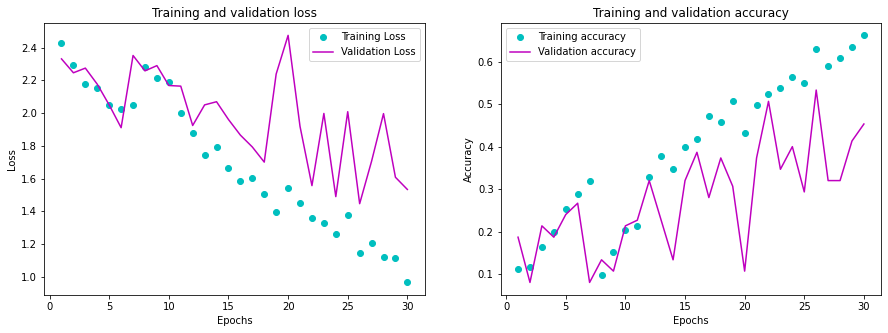

In [305]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [306]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 71ms/step - loss: 1.3278 - accuracy: 0.5800
Confusion_matrix:  tf.Tensor(
[[ 9  0  0  0  1  0  0  0  0  0]
 [ 1  8  0  0  0  0  0  0  0  1]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 3  0  0  3  1  2  0  1  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 6  0  0  0  0  3  0  0  0  1]
 [ 0  3  1  0  0  1  5  0  0  0]
 [ 1  0  2  2  0  0  1  4  0  0]
 [ 5  0  0  1  0  2  0  0  2  0]
 [ 1  4  0  0  0  1  0  0  0  4]], shape=(10, 10), dtype=int32)


In [307]:
model.save('Model-CNN-vgg16-30e-bs-10-lro-0.001-opt-sgd.h5')

# 0.0001

In [308]:
model = tf.keras.models.load_model('base2.h5')

In [309]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=opt ,loss=loss, metrics=['accuracy'])

In [310]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 4s 150ms/step - loss: 2.5721 - accuracy: 0.1034 - val_loss: 2.4090 - val_accuracy: 0.1333
Epoch 2/30
23/23 [==============================] - 3s 140ms/step - loss: 2.4502 - accuracy: 0.1569 - val_loss: 2.3264 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 3s 140ms/step - loss: 2.3258 - accuracy: 0.1180 - val_loss: 2.2815 - val_accuracy: 0.1200
Epoch 4/30
23/23 [==============================] - 3s 140ms/step - loss: 2.2070 - accuracy: 0.1516 - val_loss: 2.3020 - val_accuracy: 0.1467
Epoch 5/30
23/23 [==============================] - 3s 140ms/step - loss: 2.1452 - accuracy: 0.2018 - val_loss: 2.2278 - val_accuracy: 0.1333
Epoch 6/30
23/23 [==============================] - 3s 140ms/step - loss: 2.1499 - accuracy: 0.1774 - val_loss: 2.3373 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 3s 140ms/step - loss: 2.1231 - accuracy: 0.1996 - val_loss: 2.2400 - val_accuracy: 0.2400
Epoch 

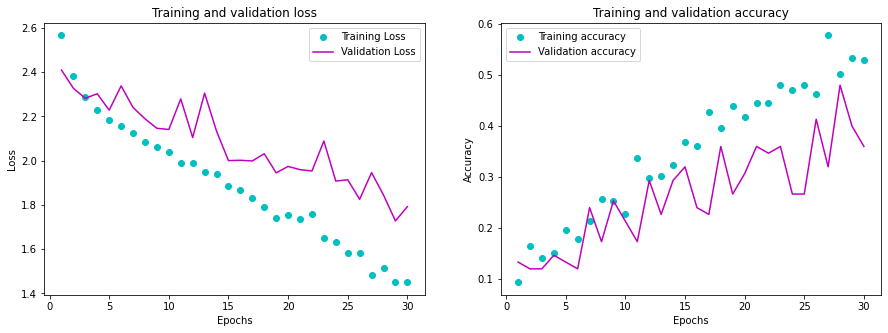

In [311]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [312]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 71ms/step - loss: 1.5749 - accuracy: 0.4400
Confusion_matrix:  tf.Tensor(
[[3 0 2 0 1 0 4 0 0 0]
 [1 6 2 0 0 0 0 0 0 1]
 [0 0 8 0 0 1 1 0 0 0]
 [3 0 0 0 0 1 0 1 5 0]
 [4 0 0 0 5 0 1 0 0 0]
 [0 0 0 0 0 3 4 0 3 0]
 [0 1 0 0 0 1 8 0 0 0]
 [2 0 2 2 0 0 0 2 2 0]
 [0 0 0 0 0 3 0 0 7 0]
 [3 0 0 0 0 1 4 0 0 2]], shape=(10, 10), dtype=int32)


# VGG 16 sin peso

In [145]:
baseModel = VGG16(weights=None,include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)

In [146]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [147]:
history = model.fit(X_train, y_train, epochs=epoch, validation_data= (X_val, y_val))

Epoch 1/30
8/8 [==============================] - 3s 330ms/step - loss: 201132472547.8099 - accuracy: 0.1082 - val_loss: 5564.8052 - val_accuracy: 0.1200
Epoch 2/30
8/8 [==============================] - 2s 301ms/step - loss: 4166.0435 - accuracy: 0.0714 - val_loss: 2.3095 - val_accuracy: 0.1067
Epoch 3/30
8/8 [==============================] - 2s 306ms/step - loss: 2.3589 - accuracy: 0.1132 - val_loss: 2.3451 - val_accuracy: 0.1067
Epoch 4/30
8/8 [==============================] - 2s 303ms/step - loss: 2.4222 - accuracy: 0.0744 - val_loss: 3.2760 - val_accuracy: 0.1067
Epoch 5/30
8/8 [==============================] - 2s 300ms/step - loss: 3.1891 - accuracy: 0.1282 - val_loss: 2.4251 - val_accuracy: 0.0800
Epoch 6/30
8/8 [==============================] - 2s 302ms/step - loss: 2.3777 - accuracy: 0.0994 - val_loss: 5.4574 - val_accuracy: 0.0667
Epoch 7/30
8/8 [==============================] - 2s 301ms/step - loss: 3.2687 - accuracy: 0.0868 - val_loss: 2.4467 - val_accuracy: 0.1067
Epo

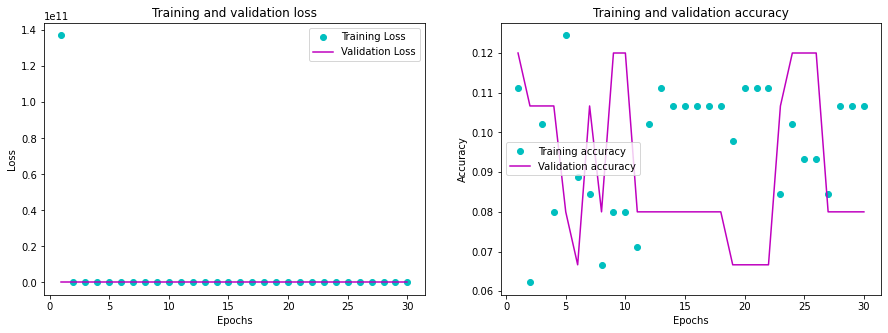

In [148]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [149]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [150]:
history = model.fit(X_train, y_train, epochs=epoch, validation_data= (X_val, y_val))

Epoch 1/30
8/8 [==============================] - 3s 345ms/step - loss: 2.3097 - accuracy: 0.1206 - val_loss: 2.3354 - val_accuracy: 0.0800
Epoch 2/30
8/8 [==============================] - 3s 325ms/step - loss: 2.3090 - accuracy: 0.1158 - val_loss: 2.3334 - val_accuracy: 0.0800
Epoch 3/30
8/8 [==============================] - 3s 320ms/step - loss: 2.3035 - accuracy: 0.0978 - val_loss: 2.3322 - val_accuracy: 0.0800
Epoch 4/30
8/8 [==============================] - 3s 315ms/step - loss: 2.3015 - accuracy: 0.1108 - val_loss: 2.3317 - val_accuracy: 0.0800
Epoch 5/30
8/8 [==============================] - 3s 362ms/step - loss: 2.2980 - accuracy: 0.1173 - val_loss: 2.3323 - val_accuracy: 0.0800
Epoch 6/30
8/8 [==============================] - 3s 320ms/step - loss: 2.3014 - accuracy: 0.1100 - val_loss: 2.3328 - val_accuracy: 0.0800
Epoch 7/30
8/8 [==============================] - 3s 314ms/step - loss: 2.3011 - accuracy: 0.0959 - val_loss: 2.3323 - val_accuracy: 0.0800
Epoch 8/30
8/8 [====

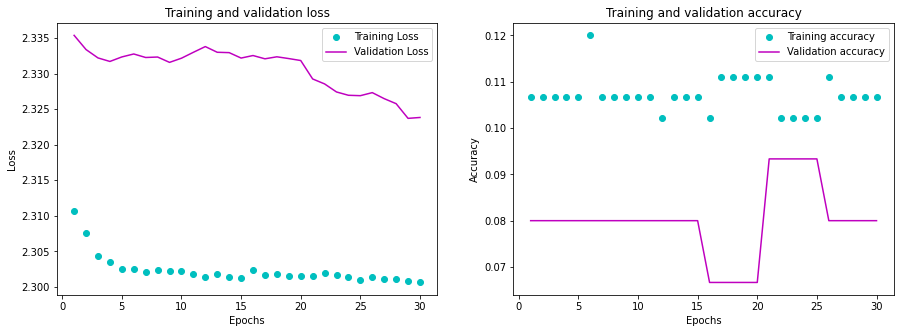

In [151]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [152]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [153]:
history = model.fit(X_train, y_train, epochs=epoch, validation_data= (X_val, y_val))

Epoch 1/30
8/8 [==============================] - 3s 337ms/step - loss: 2.3018 - accuracy: 0.0997 - val_loss: 2.3238 - val_accuracy: 0.0800
Epoch 2/30
8/8 [==============================] - 3s 313ms/step - loss: 2.3075 - accuracy: 0.1000 - val_loss: 2.3237 - val_accuracy: 0.0800
Epoch 3/30
8/8 [==============================] - 3s 314ms/step - loss: 2.3023 - accuracy: 0.0908 - val_loss: 2.3238 - val_accuracy: 0.0800
Epoch 4/30
8/8 [==============================] - 2s 310ms/step - loss: 2.2987 - accuracy: 0.1123 - val_loss: 2.3238 - val_accuracy: 0.0800
Epoch 5/30
8/8 [==============================] - 2s 310ms/step - loss: 2.2987 - accuracy: 0.1143 - val_loss: 2.3240 - val_accuracy: 0.0800
Epoch 6/30
8/8 [==============================] - 2s 305ms/step - loss: 2.3011 - accuracy: 0.0947 - val_loss: 2.3241 - val_accuracy: 0.0800
Epoch 7/30
8/8 [==============================] - 2s 305ms/step - loss: 2.2981 - accuracy: 0.0968 - val_loss: 2.3243 - val_accuracy: 0.0800
Epoch 8/30
8/8 [====

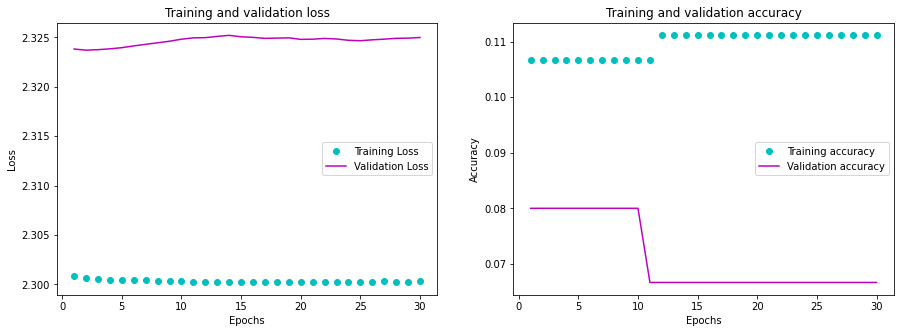

In [154]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [155]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 69ms/step - loss: 2.3065 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)
